# PHYS 325 Scientific Computing -- Fall 2018

## 3.2 Monte Carlo simulations

Reminder: Monte Carlo integration method

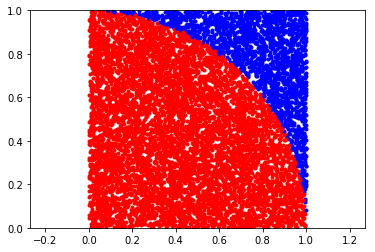

ratio =  0.7874
true value (pi/4) =  0.7853981633974483


In [9]:
# area of circle with Monte Carlo
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', 'datalim')

counter_inside = 0
counter_total = 0

steps = 10000
for i in range(steps):
    counter_total += 1
    point = np.random.rand(2)
    
    if np.sqrt(point[0]**2+point[1]**2) < 1:
        plt.plot(point[0], point[1], 'r.')
        counter_inside += 1
    else:
        plt.plot(point[0], point[1], 'b.')

plt.show()
print("ratio = ", counter_inside/counter_total)
print("true value (pi/4) = ", np.pi/4)        

Strategy:

- put function into a box (or any shape with known area)
- generate $N$ random points inside the box
- number points under curve/$N\approx$ area under curve/box area
- the larger $N$ the more precise (law of large numbers)
- error scales as $1/\sqrt{N}$ (remember the formula for errors from the data analysis lectures!)
- this scaling is **independent of dimension**

### 3.2.1 Direct sampling

In [10]:
# more advanced example: numerical integration of a difficult function

def integrand(x):
    return (np.sin(1/x/(2-x)))**2

xmin = 0
xmax = 2

# first trying the standard methods
import scipy.integrate as integrate

print("General integration: ", integrate.quad(integrand, xmin, xmax, args=()))

General integration:  (1.4516877509810688, 0.0027123781525913633)


/home/olga/.virtualenvs/v3_newlibs/lib/python3.4/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


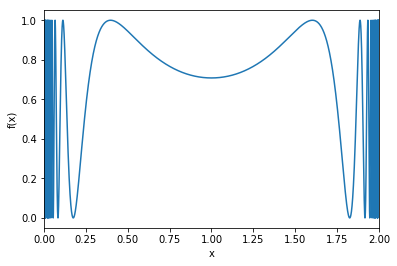

In [5]:
# Why is this integration so difficult?

x = np.arange(xmin+0.0001, xmax, 0.0001)
plt.plot(x, integrand(x))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim(xmin, xmax)
plt.show()

The integral is estimated as  1.451958


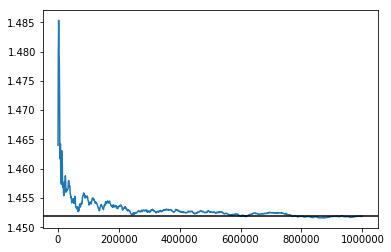

In [6]:
# the function is highly oscillating => difficult for standard methods!
# using Monte Carlo integration

steps = int(1e6)
success = 0
counter_total = 0
prelim_results, prelim_steps = [], []

interval = 2         # length of the integration interval
total_area = 2*1     # total area of the box

for i in range(steps):
    
    #normalization
    counter_total += 1
    
    # choose random point in the box with width [0,2] and height [0,1]
    point = np.random.rand(2)
    point[0] *= interval
    
    # check if point is under the curve
    if point[1] < integrand(point[0]):
        success += 1
        
    # for error estimate
    if counter_total%1000 == 0:
        prelim_results = np.append(prelim_results, success/counter_total*total_area)
        prelim_steps = np.append(prelim_steps, counter_total)  

print("The integral is estimated as ", success/steps*total_area)

plt.plot(prelim_steps, prelim_results)
plt.axhline(success/steps*total_area, color='k')
plt.show()

In [9]:
# quantitative error estimate

steps = int(1e4)
repeat = 100
prelim_results = []

# repeat shorter MC calculation many times
for i in range(repeat):
    
    success = 0
    counter = 0
    
    for j in range(steps):
        
        counter += 1
    
        # choose random point in the box with width [0,2] and height [0,1]
        point = np.random.rand(2)
        point[0] *= interval
    
        # check if point is under the curve
        if point[1] < integrand(point[0]):
            success += 1
        
    # when finished remember result
    prelim_results = np.append(prelim_results, success/counter*total_area)

numInt = np.mean(prelim_results)
numStd = np.std(prelim_results)
numErr = numStd/np.sqrt(repeat)
print("The integral is estimated as ", numInt)
print("The standard deviation is ", numStd)
print("The overall integration error is estimated as ", numErr)

The integral is estimated as  1.4485579999999998
The standard deviation is  0.008091837615770583
The overall integration error is estimated as  0.0008091837615770584


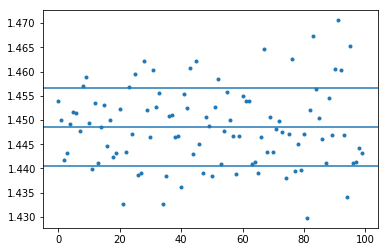

In [10]:
plt.plot(prelim_results,'.')
plt.axhline(numInt)
plt.axhline(numInt+numStd)
plt.axhline(numInt-numStd)
plt.show()

This is an example of **direct sampling** => generate points uniformly in a region

![Direct sampling](images/MCint.png)

Rewrite the integral in terms of the function average:

$$\langle f\rangle= \frac{1}{V}\int_I f(x)dx = \frac{\int_I f(x)dx}{\int_I dx},$$

where $V$ is the length of the integration interval $I$ (or volume of the integration domain in more than 1d)

To sample the function:

$$\langle f\rangle= \frac{\int_I f(x)dx}{\int_I dx}\rightarrow \frac{\sum_{x_i\in I}f(x_i)}{\sum_{x_i\in I}1} = \frac{\sum_{x_i\in I}f(x_i)}{N}$$

- choose $x_i$ uniformly,
- add $f(x_i)$ to numerator and $1$ to denominator
- repeat $N$ times

In [11]:
# another direct sampling method

steps = int(1e6)
integral = 0

for i in range(steps):
    
    # choose random point in the integration interval [0,2]
    point = interval*np.random.rand()
    
    # evaluate integrand at this point and add to integral
    integral += integrand(point)

print("The function average is estimated as ", integral/steps)
print("The integral is estimated as ", integral/steps*interval)

The function average is estimated as  0.7253449224512639
The integral is estimated as  1.4506898449025278


Note that the method we used before is the same, just combined with the rejection method!

### 3.2.2 Importance sampling

=> generate more important points (that contribute more to the integral) more often

![Importance sampling](images/MCimportance.png)

> How to ensure that we still get the right result?

$$\int_I f(x)dx = \int_I \frac{f(x)}{p(x)}p(x)dx$$

for some probability density function $p(x)$ with (by definition) $\int_I p(x)dx = 1$

$$\int_I f(x)dx=\frac{\int_I \frac{f(x)}{p(x)}p(x)dx}{\int_I p(x)dx}=\underbrace{\left\langle\frac{f(x)}{p(x)}\right\rangle_p}_{{\rm weighted}\ {\rm average}\ {\rm w.r.t.}\ p(x)}\rightarrow \frac{1}{N}\sum_{x_i\ {\rm from}\ p(x)}\frac{f(x_i)}{p(x_i)}$$

- choose $x_i$ according to $p(x_i)$
- add $f(x_i)/p(x_i)$ to numerator and 1 to denominator
- repeat $N$ times

We obtain the correct limit for the integral:

- probability that $x_i \in [x,x+dx]$ equals $p(x)dx$
- after $N$ repetitions will have $Np(x)dx$ samples of $f(x)/p(x)$ in $[x,x+dx]$
- this approximates $f(x)$ in $[x,x+dx]$

**Example:** integrand with divergence at the lower bound

$$\int_I f(x)dx =\int_0^1 \frac{1}{\sqrt{x}(e^x+1)} dx$$

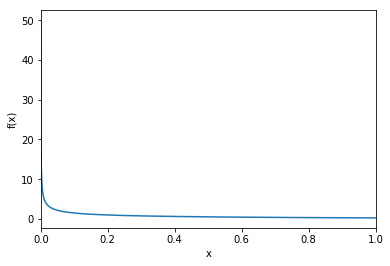

In [12]:
# example: integrand with divergence at the lower bound

def f(x):
    return 1/np.sqrt(x)/(np.exp(x)+1)

xmin = 0
xmax = 1

x = np.arange(xmin+0.0001, xmax, 0.0001)
plt.plot(x, f(x))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim(xmin, xmax)
plt.show()

This is impossible with direct sampling!

=> choose probability density that removes the divergence

$$p(x)\propto\frac{1}{\sqrt{x}}$$

Normalization:

$$\int_0^1\frac{1}{\sqrt{x}}dx=\frac{1}{2}\Rightarrow p(x)=\frac{1}{2\sqrt{x}}$$

$$\Rightarrow \frac{f(x)}{p(x)}=\frac{2}{e^x+1}$$

Reminder: transformation method

$$p(x) = p(z)\left|\frac{dz}{dx}\right|$$

In our example:

$$x(z) = z^2 \Rightarrow z = \pm\sqrt{x} \Rightarrow \left|\frac{dz}{dx}\right|=\frac{1}{2\sqrt{x}}$$

If $p(z)$ uniform => $p(x)$ is required distribution

In [13]:
# integration with importance sampling
steps = int(1e6)
integral = 0

for i in range(steps):
    z = np.random.rand()          # choose z uniformly
    x = z**2                      # transform to get x
    integral += 2/(np.exp(x)+1)   # sample f(x)/p(x)

print("The integral is estimated as ", integral/steps)

The integral is estimated as  0.8390451569242806


#### Link with thermal physics

Boltzmann probability:

$$P(E_i)=\frac{e^{-\beta E_i}}{Z} = \frac{e^{-\beta E_i}}{\sum_i e^{-\beta E_i}}$$

Thermal expectation value of an observable $A$:

$$\langle A\rangle = \sum_i A_iP(E_i)$$

or in operator notation:

$$\langle A\rangle = \frac{1}{Z}{\rm Tr} [Ae^{-\beta H}]=\frac{{\rm Tr} [Ae^{-\beta H}]}{{\rm Tr} [e^{-\beta H}]}$$

- we don't know the exact (micro)state $i$ of a system
- we only know macroscopic quantities: temperature $T$ with $\beta = 1/(k_BT)$, volume, etc.
- each state $i$ has a certain probability $P(E_i)$
- there is an extremely large number of possible states

=> simulate different states of the system with Monte Carlo, according to the thermal probability function

- most probabilities $P(E_k)$ are tiny => exponentially small
- we need importance sampling!
- use the Boltzmann probability $P(E_k)$ as probability distribution to generate $N$ samples

$$\langle A\rangle \rightarrow\frac{1}{N}\sum_{k=1}^N \underbrace{A_k}_{{\rm chosen}\ {\rm acc.}\ {\rm to}\ P(E_k)}$$

=> **simulation** of the system's path through possible states

### 3.2.3 Markov chains

> How do we generate samples according to $P(E_k)$?

- the exact form of $P(E_k)$ is unknown
- this is because we don't know the partition function $Z$ beforehand
- but it turns out that we don't need it!

Idea: random walk through the space of states

- state chosen now depends (only) on the previous state
- suggest an **update** to the next state
- update can be either accepted or rejected
- updates to regions that contribute more to the integral are more likely to be accepted (importance sampling)

![Markov chain](images/markovchain.png)

Requirements:

- **Ergodicity**: every state can be reached
- sampling with correct distribution, e.g. via **detailed balance**

$$\begin{array}{llll}
i & \sim & NP(E_i) & {\rm times} \\
i+1 & \sim & NP(E_{i+1}) & {\rm times}
\end{array}\Rightarrow{\rm prob}(i+1|i)\propto \frac{P(E_{i+1})}{P(E_i)}=\frac{e^{-\beta E_{i+1}}/Z}{e^{-\beta E_{i}}/Z}=e^{-\beta(E_{i+1}-E_{i})}
$$

> The normalization factor cancels in the detailed balance equations!

Problem:

Because every step depends on the previous step we introduce **autocorrelations**

### 3.2.4 Metropolis algorithm

- **suggest** update $i\rightarrow i+1$ with some probability $w(i\rightarrow i+1)$
- **accept** update with probability $P_{\rm acc}(i\rightarrow i+1)\!=\!\min\!\left(\!1,\frac{P(E_{i+1})}{P(E_i)}\frac{w(i\leftarrow i+1)}{w(i\rightarrow i+1)}\right)$
- **reject** otherwise (remain in state $i$)
- **sample** ("measure") the quantity of interest $A_i$ in this state
- repeat $N$ times

#### Boltzmann probability

- begin with some arbitrary state
- choose new state uniformly at random (probability $w$ is uniform)
- compute acceptance probability

  $$P_{\rm acc} = \left\{
  \begin{array} 
  \.1 &\ {\rm if}\ & E_{i+1}\leq E_i \\
  e^{-\beta(E_{i+1}-E_i)} &\ {\rm if}\ & E_{i+1}> E_i
  \end{array}\right.$$
  
- accept or reject according to this probability
- this means that we are always accepting moves that **decrease the energy**
- sometimes we may also accept moves that increase the energy

![Metropolis algorithm](images/metropolis_paper.png)

(cited ~40k times)

### 3.2.5 Ising model

- simple theoretical model of a magnet
- grid that contains a spin $s_i$ (magnetic dipole moment of atomic spin) on each grid site $i$
- the spin can have two values: up or down ($s_i=\pm1$)

![Ising model](images/ising.png)

Image [source](http://astro.pas.rochester.edu/~aquillen/phy256/ps10.html)

Energy of the Ising model

$$E = -J\sum_{\langle i,j\rangle}s_is_j$$

- $\langle i,j\rangle$ means that grid sites $i$ and $j$ are nearest neighbors (example marked in yellow in the plot)
- only nearest neighbors interact (contribute to energy)
- the sum goes over all nearest neighbor pairs on the grid
- the coupling constant $J$ determines the interaction strength
- typically $J>0$ i.e. spins want to align (ferromagnet)
- $J<0$ means that neighboring spins want to have different signs (anti-ferromagnet)

Extensions of the basic model

- we will mostly discuss the 2d case, but other dimensions are also interesting!
- non-nearest neighbor interactions
- non-square grids, e.g. hexagonal
- different boundary conditions
- coupling constant is site-dependent $J\rightarrow J_{ij}$
- more than two possible values for the spins => Potts model
- spin is a vector and can point in any direction => XY model, Heisenberg model

Introduce external magnetic field $h$:

$$E = -J\sum_{\langle i,j\rangle}s_is_j - h\sum_i s_i$$

Interesting questions:

- What do typical spin configurations look like at different temperatures?
- Are there phase transitions?
- How long does it take to reach equilibrium?
- Compute thermodynamic quantities, such as the magnetization (average value of the spin)
  
  $$m = \frac{1}{N}\sum_i s_i,$$
  
  where $N$ is the total number of spins (total number of grid cells)
  
#### Basic simulation of the 2d Ising model with the Metropolis algorithm

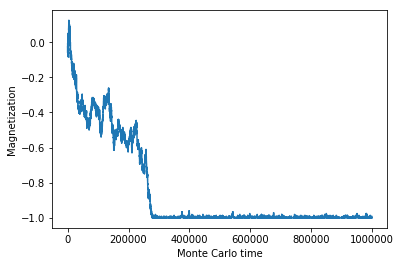

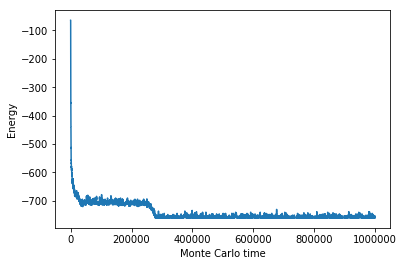

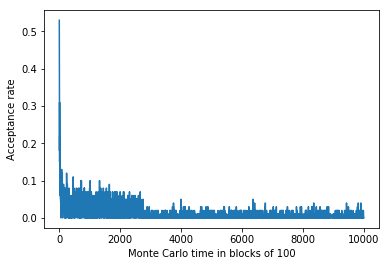

In [16]:
# define the system parameters

L = 20      # size of lattice in each direction
J = 1       # interaction parameter
h = 0       # magnetic field
T = 1       # temperature
beta = 1/T  # set k_B = 1

# define the state of the system: LxL grid with (initially) a random spin in each cell
config = 2*np.random.randint(2, size=(L,L))-1

# energy of a given state
def energy():  
    # elegant way of writing the sum over all nearest neighbors in the grid
    interaction = -J*( np.sum(config[0:L-1,:]*config[1:L,:]) +     # contributions of top/bottom neighbors
                       np.sum(config[:,0:L-1,]*config[:,1:L]))     # contributions of left/right neighbors
    
    magnetic = -h*np.sum(config)
    return interaction + magnetic

current_energy = energy()

# magnetization of a given state
def magnetization():
    return np.sum(config)/L/L

# Monte Carlo update using Metropolis algorithm
def update():
    
    global config, current_energy    # we want to be able to change the configuration
    
    # choose a random cell in the grid
    cell = np.random.randint(L, size=2)
    i = cell[0]
    j = cell[1]
    
    # calculate the current contribution of this cell to the total energy
    energy_cell = 0
    # be careful with the boundary
    if i != 0:   energy_cell += config[i-1, j]   # left neighbor
    if i != L-1: energy_cell += config[i+1, j]   # right neighbor
    if j != 0:   energy_cell += config[i, j-1]   # top neighbor
    if j != L-1: energy_cell += config[i, j+1]   # bottom neighbor
        
    # the current contribution to the interaction energy is: -J*energy_cell*config[i,j]
    # if we flip the spin, i.e. change config[i,j] to -config[i,j], the new contribution will also change sign
    # this means that overall:
    
    energy_difference = 2*J*energy_cell*config[i,j]
    
    # additional contribution due to the magnetic field
    energy_difference += 2*h*config[i,j]
    
    # check if update is accepted
    accept = False
    if energy_difference<0: 
        accept = True    # always accept updates that decrease the energy
    else:
        prob = np.exp(-beta*energy_difference)
        # standard to calculate event given a probability (see example biasedCoin() in Section 3.1.3)
        rand = np.random.rand()
        if rand<prob:
            accept = True
            
    # if update is accepted we flip the spin
    if accept == True:
        config[i, j] = -config[i, j]
        current_energy += energy_difference
    
    # keep track of the acceptance probability
    return accept

# run the simulation
steps = int(1e6)
magnetization_results = []
energy_results = []
accept_results = []
accept_counter = 0

for counter in range(steps):

    accept_counter += update()
    # keep track of acceptance rates in blocks of 100 steps
    if counter%100 == 99:
        accept_results.append(accept_counter/100)
        accept_counter=0
    
    energy_results.append(current_energy)
    magnetization_results.append(magnetization())
    
plt.plot(magnetization_results)
plt.xlabel("Monte Carlo time")
plt.ylabel("Magnetization")
plt.show()

plt.plot(energy_results)
plt.xlabel("Monte Carlo time")
plt.ylabel("Energy")
plt.show()

plt.plot(accept_results)
plt.xlabel("Monte Carlo time in blocks of 100")
plt.ylabel("Acceptance rate")
plt.show()

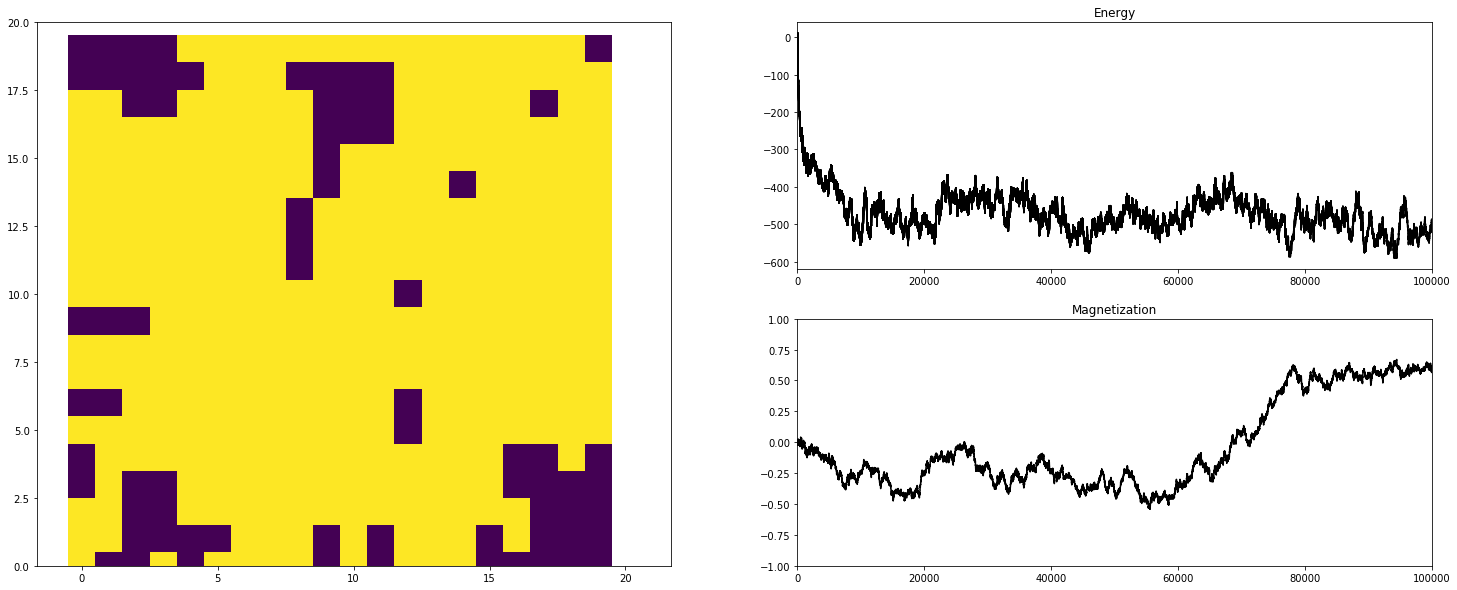

In [15]:
# Animation of the Ising model states
%matplotlib inline
import matplotlib.animation as animation

# prepare system parameters
L = 20      # size of lattice in each direction
J = 1       # interaction parameter
h = 0       # magnetic field
T = 2.23       # temperature
beta = 1/T  # set k_B = 1
config = 2*np.random.randint(2, size=(L,L))-1
current_energy = energy()

# prepare plots
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 4)

# simulation parameters
steps = int(1e5)
steps_per_frame = int(4e3)
num_frames = int(steps/steps_per_frame)
magnetization_results = []
energy_results = []

# perform simulation
def animate(i):
       
    plt.cla()
    
    ax1.imshow(config)
    ax1.set_xlim(0,L)
    ax1.set_ylim(0,L)
    ax1.set_aspect('equal', 'datalim')
        
    ax2.plot(energy_results, 'k')
    ax2.set_xlim(0, steps)
    ax2.set_title("Energy")
        
    ax3.plot(magnetization_results, 'k')
    ax3.set_xlim(0, steps)
    ax3.set_ylim(-1,1)
    ax3.set_title("Magnetization")
    
    for j in range(steps_per_frame):
        acc = update()
        energy_results.append(current_energy)
        magnetization_results.append(magnetization())

# produce animation
simulation = animation.FuncAnimation(fig, animate, frames = num_frames, repeat = False)

from IPython.display import HTML
HTML(simulation.to_jshtml())

There are are also many simulations of the Ising model available online, for example

- https://mattbierbaum.github.io/ising.js/
- https://physics.weber.edu/schroeder/software/demos/IsingModel.html

**Physical results** for the 2d Ising model ($h=0$): 

Simulation data (points) and exact results (lines) for the magnetization $m$ and specific heat $c= \frac{\beta^2}{N}(\langle E^2\rangle -\langle E\rangle^2)$ versus temperature

-- from *"Monte Carlo Methods in Statistical Physics"* by M. E. J. Newman and G. T. Barkema: an excellent book on Monte Carlo methods, you can download the first four chapters, which are the most relevant ones for this section, [here](http://itf.fys.kuleuven.be/~fpspXIII/material/Barkema_FPSPXIII.pdf)

![newman_barkema_ising_cm.png](images/newman_barkema_ising_cm.png) | ![newman_barkema_ising_m.png](images/newman_barkema_ising_m.png)  | ![newman_barkema_ising_c.png](images/newman_barkema_ising_c.png)
---|---|---
$5\times 5$ grid | $100\times100$ grid |  $100\times100$ grid

You can clearly see signs of a phase transition!

=> critical temperature $T_c=\frac{2J}{\log(1+\sqrt{2})}\approx2.269J$

- $T>T_c$ paramagnetic phase: average magnetization is zero
- $T<T_c$ ferromagnetic phase: spontanous magnetization
- the magnetization is the **order parameter** of the **phase transition** (characterizes the phase transition)
- magnetization continuous across transition: **continous phase transition** (here: second order phase transition)
- in the **critical region** the system forms **large domains**
- note the large error bars there: **critical slowing down**

So far we have been chosing the cells for the Monte Carlo updates uniformly

- inefficient when we are close to equilibrium, when only few cells can further improve the overall energy
- critical slowing down near the phase transition (it is difficult to flip a whole domain spin by spin)

#### The Wolff algorithm

- flip entire cluster in one go => **cluster algorithm**
- pick one spin first
- check which of its neighbors point in the same direction
- then check neighbors of neighbors and so on
- can either find the whole cluster or, better,

  => cluster size depends on temperature!
  
    - high $T$ $\leftrightarrow$ spin uncorrelated $\leftrightarrow$ small clusters
    - critical $T$ $\leftrightarrow$ spins correlated $\leftrightarrow$ large clusters
    - low $T$ $\leftrightarrow$ spins aligned $\leftrightarrow$ essentially one cluster
    
  => add spin to cluster with a certain probability $P_{\rm add}(T)$
  
  ![Wolff algorithm clusters](images/wolff_clusters.png)
  
  image from book by Newman and Barkema
  
- when cluster formed, accept or reject flipping it
- assume that $m$ bonds need to broken for the forward move $i\rightarrow i+1$
  
  assume that $n$ bonds need to broken for the reverse move $i\leftarrow i+1$
  
  broken bonds are pairs of aligned spins, where the partner spin has *not been added* to the cluster

  => detailed balance acceptance probability:

  $$P_{\rm acc}=\frac{P(E_{i+1})}{P(E_i)}\frac{w(i\leftarrow i+1)}{w(i\rightarrow i+1)}
  =\frac{e^{-\beta E_{i+1}}}{e^{-\beta E_{i}}}\frac{(1-P_{\rm add})^n}{(1-P_{\rm add})^m}=e^{-\beta (E_{i+1}-E_i)}(1-P_{\rm add})^{n-m}=e^{-2\beta J(n-m)}(1-P_{\rm add})^{n-m}$$
  
- trick: choose $P_{\rm add}=1-e^{-2\beta J}$ 
- this cancels the other term in $P_{\rm acc}$ so that $P_{\rm acc}=1$ => update **always accepted**!
- this is the best possible acceptance probability we can get!

#### Summary of the Wolff algorithm

- pick a grid cell at random
- check all neighbors of this cell
    - if they have the same spin, add the neighbors to the cluster with probability $1-e^{-2\beta J}$
    - for each cell that was added in the last step, check its neighbors
    - if they are already part of the cluster, skip them (otherwise you will never stop)
    - if they are not part of the cluster and have the same spin, add them with probability $1-e^{-2\beta J}$
    - some cells might have been considered for addition before and rejected => they get another chance
- repeat until there are no cells left whose neighbors have not been considered
- flip the entire cluster

![Wolff algorithm configurations](images/wolff_configs.png)

image from book by Newman and Barkema

#### Summary of different methods for the Ising model

- Metropolis algorithm is simple and efficient away from the critical region
- Wolff algorithm is better near the critical point, but more complex to program
- Swendsen-Wang algorithm: like Wolff algorithm but attempt to flip all clusters in one step (independently from each other with probability $1/2$)
- Niedermayer's algorithm: generalization of the Wolff algorithm so that clusters can include different spins (addition probability depends on energy difference)

### 3.2.6 Simulated annealing

Monte Carlo technique for the **numerical optimization** of functions

Original paper: [S. Kirkpatrick, C. D. Gelatt, Jr., M. P. Vecchi, Science 220, 671-680 (1983)](http://science.sciencemag.org/content/220/4598/671.long)

Remember: it is difficult to find the **global** extremum of a function

Idea: Monte Carlo search of the function domain

![Simulated Annealing](images/Hill_Climbing_with_Simulated_Annealing.gif)

Animation source: [Wikipedia](https://en.wikipedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif), by Kingpin13, CC0

Finding thermal ground state (energy minimum) of a statistical system $\leftrightarrow$ finding minimum (or similarly maximum) of any function

- introduce (artificial) temperature parameter $T$
- Metropolis algorithm with acceptance probability min$(1, e^{-\Delta f/T})$
- here $f$ can be any function we want to minimize (not only energy)
- for maximum simply change the sign: min$(1, e^{+\Delta f/T})$
- slowly reduce the temperature

This **slow cooling** is the main idea of simulated annealing

very high $T$                                |   very low $T$
---------------------------------------------|------------------------------------
almost all updates are accepted              | only updates that decrease the energy are accepted
random configurations/explore entire space   | descend towards minimum 
high energy                                  | low energy but might get stuck in local minimum
  
- if we slowly cool from high $T$ to low $T$ we will explore the entire space until we converge to the (hopefully) global minimum
- success is not guaranteed, but the methods works very well with good cooling schemes

Inspiration: annealing in metallurgy

![Annealing a silver strip](images/Annealing_a_silver_strip.JPG)

Image source: [Wikipedia](https://commons.wikimedia.org/wiki/File:Annealing_a_silver_strip.JPG), by Mauro Cateb, CC BY-SA 3.0

This is a great method to tackle **NP-hard** optimization problems, such as the traveling salesman!

#### Cooling schedules

- slow cooling is essential: otherwise the system will "freeze" into a local minimum
- but too slow cooling is inefficient...
- initial temperature should be high enough so that the system is essentially random and equilibrates quickly
- final temperature should be small enough so that we are essentially in the ground state (system no longer changes)
- exponential **cooling schedule** is commonly used

  $$T(t)=T_0e^{-t/\tau},$$
  
  where $t$ is the Monte Carlo time and the constant $\tau$ needs to be determined (usually empirically)
  
- alternative cooling schedules:

  linear: $T(t)=T_0 - t/\tau$ (also widely used)
  
  logarithmic: $T(t) = c/\log(1+t/\tau)$

  
**Example:** global minimum of the function $f(x) = x^2 -\cos (4\pi x)$

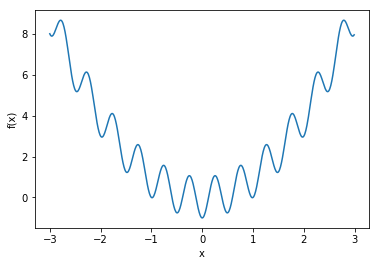

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x*x - np.cos(4*np.pi*x)

xplot = np.arange(-3,3,0.01)
plt.plot(xplot, f(xplot))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()
# the global minimum is at x = 0

In [19]:
# global minimum search using simulated annealing

x = 2                 # start value for x
temperature = 10.0    # initial temperature
tempmin = 1e-4        # minimal temperature (stop annealing when this is reached)
cooltime = 1e4        # cooling time tau for exponential schedule
xlog = []             # list storing generated x-values
mean = 0              # parameter for MC update
sigma = 1             # parameter for MC update

# after every MC step we reduce the temperature
# alternatively we could only reduce it every N steps
def cool(temperature):
    return temperature*np.exp(-1/cooltime)

def MCupdate(x):
    # the new suggested x-value is the old one plus a Gaussian random number
    # this means we are trying to make a small step away from the old value
    xnew = x + np.random.normal(mean, sigma)
    
    # check if we accept the update -> Metropolis probability
    accept = False
    delta_f = f(xnew) - f(x)
    if delta_f < 0:
        accept = True
    else:
        prob = np.exp(-delta_f/temperature)
        if np.random.rand() < prob:
            accept = True
            
    if accept == True:
        x = xnew
        
    return x

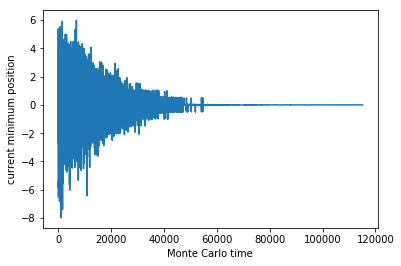

Final search result for the global minimum:  -0.0006645872395418109


In [120]:
# main code for simulated annealing search

while temperature > tempmin:
    # update x-value with Metropolis algorithm
    x = MCupdate(x)
    # cool the system
    temperature = cool(temperature)
    # collect the x-value
    xlog.append(x)

# output results
plt.plot(xlog)
plt.xlabel('Monte Carlo time')
plt.ylabel('current minimum position')
plt.show()
print('Final search result for the global minimum: ', x)

In this example: minimum of a continuous function

=> always slightly above true minimum if $T>0$

=> best combined with a steepest descent method

#### Simulated annealing for the Ising model

$$E = -J\sum_{\langle i,j\rangle}s_is_j - h\sum_i s_i$$

find the ground state by slow cooling

The calculated ground state energy is  -760
The true ground state energy is  -760.0


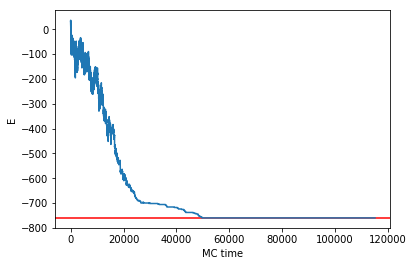

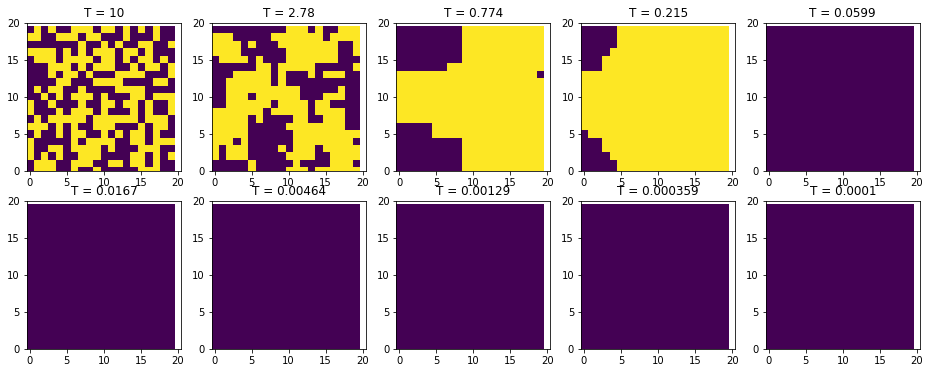

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Set up simulated annealing --------------------------------------------------------------

temperature = 10.0    # initial temperature
tempmin = 1e-4        # minimal temperature (stop annealing when this is reached)
cooltime = 1e4        # cooling time tau for exponential schedule

# how long it will take to cool to minimal temperature in MC steps
MCtime = -cooltime*np.log(tempmin/temperature)

# after every MC step we reduce the temperature
def cool(temperature):
    return temperature*np.exp(-1/cooltime)

# Metropolis algorithm part of the code (same as before) -----------------------------------

L = 20      # size of lattice in each direction
J = 1       # interaction parameter
h = 0       # magnetic field

# define the state of the system: LxL grid with (initially) a random spin in each cell
config = 2*np.random.randint(2, size=(L,L))-1

# energy of a given state
def energy(config):  
    # elegant way of writing the sum over all nearest neighbors in the grid
    interaction = -J*( np.sum(config[0:L-1,:]*config[1:L,:]) +     # contributions of top/bottom neighbors
                       np.sum(config[:,0:L-1,]*config[:,1:L]))     # contributions of left/right neighbors
    
    magnetic = -h*np.sum(config)
    return interaction + magnetic

current_energy = energy(config)

# Monte Carlo update using Metropolis algorithm
def update():
    
    global config, current_energy    # we want to be able to change the configuration
    
    # choose a random cell in the grid
    cell = np.random.randint(L, size=2)
    i = cell[0]
    j = cell[1]
    
    # calculate the current contribution of this cell to the total energy
    energy_cell = 0
    # be careful with the boundary
    if i != 0:   energy_cell += config[i-1, j]   # left neighbor
    if i != L-1: energy_cell += config[i+1, j]   # right neighbor
    if j != 0:   energy_cell += config[i, j-1]   # top neighbor
    if j != L-1: energy_cell += config[i, j+1]   # bottom neighbor
        
    # the current contribution to the interaction energy is: -J*energy_cell*config[i,j]
    # if we flip the spin, i.e. change config[i,j] to -config[i,j], the new contribution will also change sign
    # this means that overall:
    
    energy_difference = 2*J*energy_cell*config[i,j]
    
    # additional contribution due to the magnetic field
    energy_difference += 2*h*config[i,j]
    
    # check if update is accepted
    accept = False
    if energy_difference<0: 
        accept = True    # always accept updates that decrease the energy
    else:
        prob = np.exp(-energy_difference/temperature)
        # standard to calculate event given a probability
        rand = np.random.rand()
        if rand<prob:
            accept = True
            
    # if update is accepted we flip the spin
    if accept == True:
        config[i, j] = -config[i, j]
        current_energy += energy_difference
    
    # keep track of the acceptance probability
    return accept

# Run the main code ----------------------------------------------------------------------

energy_results = []
config_snapshots = []
T_snapshots = []
number_snapshots = 9    # the total number will be 10 (0 to 9 inclusive)
freq_snapshots = int(MCtime/number_snapshots)

for i in range(int(MCtime)):
    # update spin configuration with Metropolis algorithm
    update()
    # cool the system
    temperature = cool(temperature)
    # record the energy
    energy_results.append(current_energy)
    # occasionally take a snapshot of the configuration
    if i%freq_snapshots == 0:
        config_snapshots.append(np.copy(config))    # don't forget to take a deep copy!
        T_snapshots.append(temperature)

print("The calculated ground state energy is ", current_energy)
print("The true ground state energy is ", energy(np.ones((L,L))))  # everything aligned

plt.axhline(current_energy, color='r')
plt.plot(energy_results)
plt.xlabel("MC time")
plt.ylabel("E")
plt.show()
    
fig, ax = plt.subplots(2, len(config_snapshots)//2, figsize=(16, 6))
ax = ax.ravel()

for i in range(len(config_snapshots)):
    ax[i].imshow(config_snapshots[i])
    ax[i].set_xlim(0,L)
    ax[i].set_ylim(0,L)
    ax[i].set_title("T = {0:.3g}".format(T_snapshots[i]))
    ax[i].set_aspect('equal', 'datalim')

#### Parallel tempering

Simulated annealing is not guaranteed to find the global extremum (unless you cool infinitely slowly)

=> usually need to repeat search

Automate this: parallel tempering (also called **replica exchange Markov chain Monte Carlo**)

- simulate several copies of the system in parallel
- each copy is at a different constant temperature $T$
- usual Metropolis updates for each copy
- every certain number of steps attempt to exchange copies at neighboring temperatures
- exchange acceptance probability is min(1, $e^{-\Delta f\Delta\beta}$)
- if temperature difference small enough, the energy histograms of the copies will overlap

  ![Parallel tempering histogram overlap](images/paralleltemperingoverlap.jpeg)

  Image from [this article](https://aip.scitation.org/doi/10.1063/1.3592153)

Advantages:

- exchanges allow to explore different extrema
- more successful for complex functions/energy landscapes
- they also ensure detailed balance (regular simulated annealing breaks detailed balance)

=> random walk in temperature space

Temperature distributions:

- a dense temperature grid increases the exchange acceptance rates...
- ...but takes longer to simulate and more steps are needed to move from one temperature to another
- there are many options, often trial and error is needed
     - exchange acceptance probability should be between about 20% and 80%
     - exchange acceptance probability should be approximately temperature-independent
     - commonly used: geometric progression
     
       $$T_n = T_{\rm min}\left(\frac{T_{\rm max}}{T_{\rm min}}\right)^{\frac{n-1}{N-1}}$$
       
       for $N$ temperatures $T_n$ between and including $T_{\rm min}$ and $T_{\rm max}$
       
       (ensures more steps around $T_{\rm min}$)
       
- make sure to spend enough time before swapping to achieve equilibrium

Current energy of copy at lowest temperature is  -760
The calculated ground state energy is  -760
The true ground state energy is  -760.0


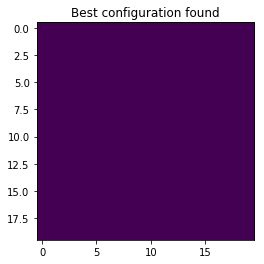

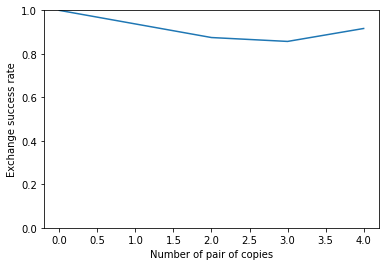

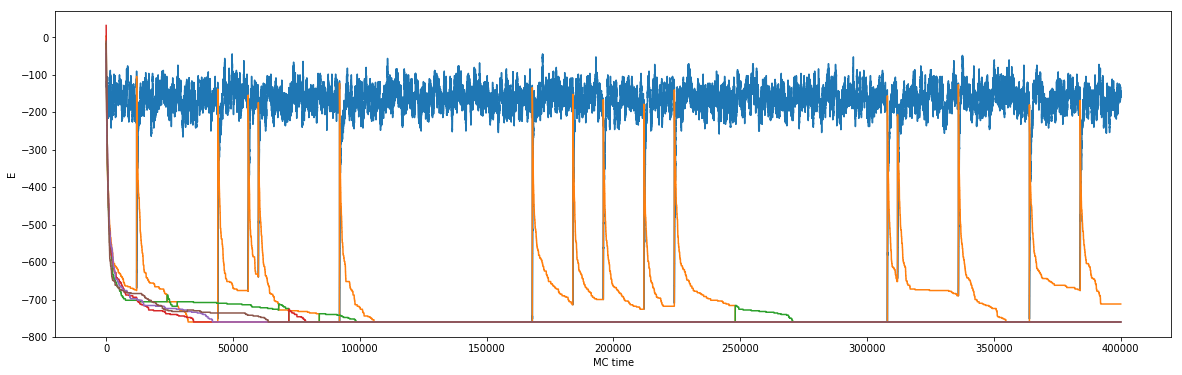

In [119]:
# Parallel tempering simulation of the Ising model ----------------------------------------

temperatureList = [5.0, 0.01, 0.0008, 0.0007, 0.00016, 0.00010]
numberCopies = len(temperatureList)

L = 20      # size of lattice in each direction
J = 1       # interaction parameter
h = 0       # magnetic field

# initialize each system copy randomly
configList = []
for i in range(numberCopies):
    configList.append( 2*np.random.randint(2, size=(L,L))-1 )

# energy of a given configuration
def energy(config):  
    # elegant way of writing the sum over all nearest neighbors in the grid
    interaction = -J*( np.sum(config[0:L-1,:]*config[1:L,:]) + 
                       np.sum(config[:,0:L-1,]*config[:,1:L]))
    
    magnetic = -h*np.sum(config)
    return interaction + magnetic

energyList = []
for i in range(numberCopies):
    energyList.append( energy(configList[i]) )

# regular Monte Carlo update using Metropolis algorithm -----------------------
def update(config, current_energy, temperature):
       
    # choose a random cell in the grid
    cell = np.random.randint(L, size=2)
    i = cell[0]
    j = cell[1]
    
    # calculate the current contribution of this cell to the total energy
    energy_cell = 0
    # be careful with the boundary
    if i != 0:   energy_cell += config[i-1, j]   # left neighbor
    if i != L-1: energy_cell += config[i+1, j]   # right neighbor
    if j != 0:   energy_cell += config[i, j-1]   # top neighbor
    if j != L-1: energy_cell += config[i, j+1]   # bottom neighbor
    
    energy_difference = 2*J*energy_cell*config[i,j]
    
    # additional contribution due to the magnetic field
    energy_difference += 2*h*config[i,j]
    
    # check if update is accepted
    accept = False
    if energy_difference<0: 
        accept = True
    else:
        prob = np.exp(-energy_difference/temperature)
        rand = np.random.rand()
        if rand<prob:
            accept = True
            
    # if update is accepted we flip the spin
    if accept == True:
        config[i, j] = -config[i, j]
        current_energy += energy_difference
    
    return config, current_energy

# attempt to exchange two specific copies i and j ----------------------------
def exchange(i, j):
    
    global configList, energyList
    
    deltaBeta = 1/temperatureList[i] - 1/temperatureList[j]
    deltaEnergy = energyList[i] - energyList[j]
    
    # check if update is accepted
    accept = False
    if deltaBeta*deltaEnergy < 0: 
        accept = True
    else:
        prob = np.exp(-deltaBeta*deltaEnergy)
        rand = np.random.rand()
        if rand<prob:
            accept = True
            
    # if update accepted we switch the configurations
    if accept == True:
        configList[i], configList[j] = configList[j], configList[i]
        energyList[i], energyList[j] = energyList[j], energyList[i]
        
    return accept

# Run the main code ----------------------------------------------------------------------

# number of steps between each exchange
exchangeSteps = 10*L*L       # at least the number of sites: allows us to "sweep" the whole grid
numberExchanges = 100

# keep track of statistics
energy_results = []
success = np.zeros(numberCopies-1)
tries = np.zeros(numberCopies-1)

# remember best configuration
best_conf = configList[-1]
best_energy = energyList[-1]

for i in range(numberExchanges):
    
    # attempt to exchange two copies      
    # select random pair of copies at neighboring temperatures
    Tlower = np.random.randint(numberCopies-1)
    tries[Tlower] += 1
    success[Tlower] += exchange(Tlower, Tlower+1)
    
    # regular Metropolis updates
    for j in range(exchangeSteps):
        # update each copy with Metropolis algorithm
        for k in range(numberCopies):
            configList[k], energyList[k] = update(configList[k], energyList[k], temperatureList[k])

        # record the energies
        energy_results.append( np.copy(energyList) )
        
        # check for energy minimum
        if energyList[-1] < best_energy:
            best_energy = energyList[-1]
            best_conf = np.copy(configList[-1])

print("Current energy of copy at lowest temperature is ", energyList[-1])
print("The calculated ground state energy is ", best_energy)
print("The true ground state energy is ", energy(np.ones((L,L))))

plt.imshow(best_conf)
plt.title("Best configuration found")
plt.show()

plt.plot(success/tries)
plt.xlabel("Number of pair of copies")
plt.ylabel("Exchange success rate")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(20,6)) 
plt.plot(energy_results)
plt.xlabel("MC time")
plt.ylabel("E")
plt.show()

More advanced versions:

- spend less time at higher temperatures, since they equilibrate faster
- can estimate beforehand how long it takes for each temperature to equilibrate
- exchange frequencies between different pairs of temperatures can also be different
- easily parallelizable